In [3]:
from math import log2, ceil
import librosa
import numpy as np
from utils import *

def interpolate_sounds(source, target, alpha, sr=44100, fft='stft', method='emd', **kwargs):

    if fft == 'stft':
        window_size = kwargs.get('window_size', 20) # ms
        window_size_samples = window_size * 1e-3 * sr
        n_fft = 2 ** ceil(log2(window_size_samples))
        source_stft = librosa.stft(source, n_fft=n_fft)
        target_stft = librosa.stft(target, n_fft=n_fft)

        stft_frequency = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

        # Optimal transport

        n_frames = source_stft.shape[1]
        
        stft_interpolation = np.zeros_like(source_stft)
        
        for frame in range(n_frames):
            
            source_frame, source_frame_relative_amplitude = normalized_frame(source_stft, frame)
            target_frame, target_frame_relative_amplitude = normalized_frame(target_stft, frame)
            
            interpolated_frame_relative_amplitude = (1-alpha) * source_frame_relative_amplitude + alpha * target_frame_relative_amplitude
            
            if method == 'quantile':
                stft_interpolation[:, frame] = quantile_optimal_transport(source_frame, target_frame, alpha=alpha) * interpolated_frame_relative_amplitude

            if method == 'emd':
                stft_interpolation[:, frame] = emd_optimal_transport(stft_frequency, source_frame, target_frame, alpha=alpha) * interpolated_frame_relative_amplitude

        interpolation = librosa.griffinlim(stft_interpolation, n_iter=100)

        return interpolation

    if fft == 'fft':

        source_fft = np.fft.rfft(source)
        target_fft = np.fft.fft(target)
        fft_frequency = np.fft.fftfreq(len(source), d=1/sr)
        fft_frequency = fft_frequency[:len(fft_frequency) // 2]
        n = len(fft_frequency)

        source_fft_magnitude = np.abs(source_fft)[:n]
        source_fft_magnitude /= np.sum(source_fft_magnitude)
        target_fft_magnitude = np.abs(target_fft)[:n]
        target_fft_magnitude /= np.sum(target_fft_magnitude)

        if method == 'quantile':
            fft_interpolation = quantile_optimal_transport(source_fft_magnitude, target_fft_magnitude, alpha=alpha)

        if method == 'emd':
            fft_interpolation = emd_optimal_transport(fft_frequency, source_fft_magnitude, target_fft_magnitude, alpha=alpha)

        interpolation = np.fft.ifft(fft_interpolation)

        return interpolation


In [18]:
# Generate two artificial

sr = 44100
duration = 1.5
frames = np.arange(duration * sr) / sr

smooth_len = 1000 # smoothing heavily affects results on stfts cause GL alg ?
smoothing = np.linspace(0, 1, smooth_len)

A4_freq = 440
A_signal = np.sin(2 * np.pi * A4_freq * frames)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)

C6_freq = 1046.5
C_signal = np.sin(2 * np.pi * C6_freq * frames)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)


In [4]:
# Load two real signals

sr = 44100
duration = 3
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A_signal, sr = librosa.load('sounds/real/A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('sounds/real/C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)


In [5]:
reconstructed_A = np.fft.ifft(np.abs(np.fft.fft(C_signal)))

widget = audio_widget(reconstructed_A, 'reconstructed A')

widget

/Users/davidvaldivia/IASD/memoire/audio_ot/audio_1D_transport/.venv/lib/python3.9/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [6]:
method = 'quantile'
fft = 'stft'
alphas = np.linspace(0, 1, 11)

interpolations = [interpolate_sounds(A_signal, C_signal, alpha=alpha, method=method, fft=fft) for alpha in alphas]

fft_signals = [A_signal, C_signal] + interpolations
fft_titles = ['A', 'C'] + [f'{method} interpolation - alpha={alpha:.2f}' for alpha in alphas]

audio_widgets = [audio_widget(signal, title) for signal, title in zip(fft_signals, fft_titles)]

grid = widgets.VBox(audio_widgets)
grid

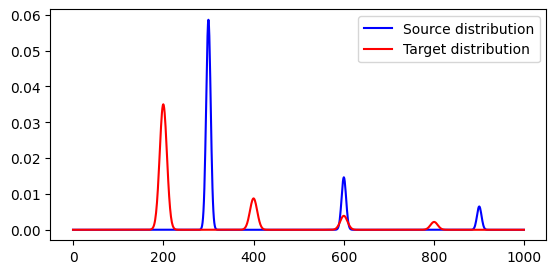

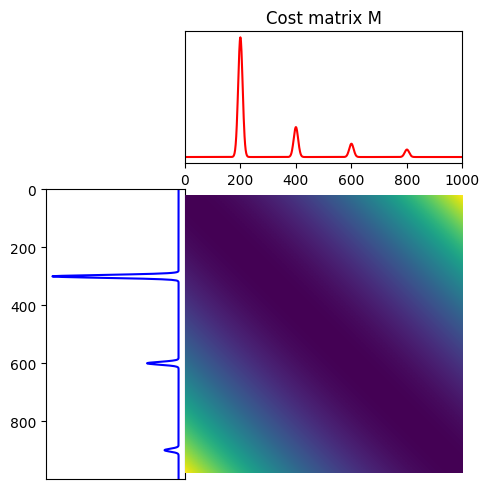

In [1]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from utils import *

n = 1000  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)


gaussian_size = 1000

gaussian_f1 = gaussian_size * 0.3
gaussian_f2 = gaussian_size * 0.2
gaussian_s1 = gaussian_size * 0.005
gaussian_s2 = gaussian_size * 0.008

# Gaussian distributions
a = natural_gaussian(gaussian_f1, gaussian_s1, gaussian_size)
b = natural_gaussian(gaussian_f2, gaussian_s2, gaussian_size)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()

pl.figure(1, figsize=(6.4, 3))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')
pl.legend()

pl.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, M, 'Cost matrix M')

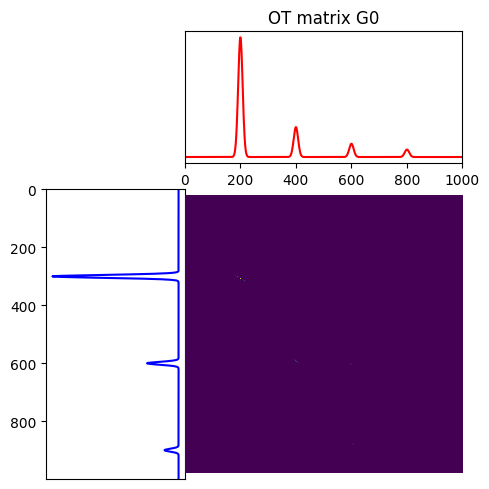

In [2]:
# use fast 1D solver
G0 = ot.emd_1d(x, x, a, b)

# Equivalent to
# G0 = ot.emd(a, b, M)

pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, G0, 'OT matrix G0')

In [3]:
G0[np.isnan(G0)] = 0
emd_interpolation = np.zeros(gaussian_size)
for i in range(gaussian_size):
    for j in range(gaussian_size):
        index = get_frequency(i, j, alpha=0.5, method='int')
        emd_interpolation[index] += G0[i][j]
emd_interpolation /= np.sum(emd_interpolation)

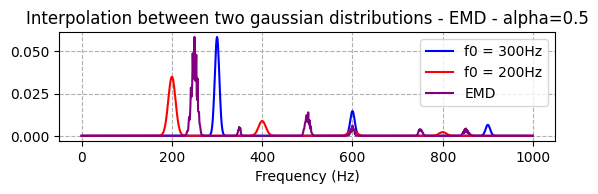

In [5]:
# Second subplot for A, C, and EMD interpolation
pl.subplot(3, 1, 2)  # 2 rows, 1 column, second plot
pl.plot(x, a, label=f"f0 = {gaussian_f1:.0f}Hz", color='blue', linewidth=1.5)
pl.plot(x, b, label=f"f0 = {gaussian_f2:.0f}Hz", color='red', linewidth=1.5)
pl.plot(x, emd_interpolation, label='EMD', color="purple")
pl.xlabel('Frequency (Hz)')
pl.title(f'Interpolation between two gaussian distributions - EMD - alpha={0.5}')
pl.grid(True, which="both", ls="--")
pl.legend()